In [2]:
from BMI_HBVmountain_Python import *

## Load forcing data

In [3]:
forcing = pd.read_csv('Data/ThunderCreek/forcing_thundercreek.csv', index_col=[0], parse_dates=True)
pd.to_datetime(forcing.index);
forcing = forcing.reset_index(level=0)
for i in range(len(forcing)):
    forcing['time'][i] = forcing['time'][i].date()
forcing.set_index('time', inplace=True)
forcing

C:\Users\Vincent Hoogelander\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,streamflow,temp_era5,prec_era5
time,,,
1986-01-01,0.962825,-4.225952,18.505061
1986-01-02,0.971722,-4.649109,4.130639
1986-01-03,0.953927,-4.009430,5.363479
1986-01-04,0.944712,-5.197113,0.000000
1986-01-05,0.944712,-3.785156,10.307294
...,...,...,...
2005-12-27,6.451560,-0.104980,16.528907
2005-12-28,5.173832,-1.296906,18.620241
2005-12-29,4.535126,-3.694000,4.846727


## Setting up the model

In [4]:
model = BMI_HBVmountain()

In [5]:
config_file = model.setup()

In [6]:
model.initialize(config_file)

### Parameters => implement in model.setup()

In [11]:
bare_parameters, forest_parameters, grass_parameters, rip_parameters,  slow_parameters, parameters_array =  Main.parameter_selection() #Generate random parameterset
model.set_value('bare_parameters', bare_parameters)
model.set_value('forest_parameters', forest_parameters)
model.set_value('grass_parameters', grass_parameters)
model.set_value('rip_parameters', rip_parameters)
model.set_value('slow_parameters', slow_parameters)

### Forcings

In [7]:
model.set_value('Temperature', (forcing['temp_era5'].values).reshape(len(forcing),1))
model.set_value('Precipitation', (forcing['prec_era5'].values).reshape(len(forcing),1))

model.set_value('Date', list(forcing.index.values))
model.set_value('Current_Date', forcing.index.values[0])

### Initial settings => implement in model.setup()

In [22]:
model.set_value('Elevation', Main.Elevations(500, 500, 2500, 1500, 1500)) # 4 Elevation bands

model.set_value('Glacier', [0.0, 0.0, 0.0, 0.6]) # 60% of the area glacier at highest elevation band
model.set_value('Sunhours', [8.87, 10.30, 11.88, 13.65, 15.13, 15.97, 15.58, 14.25, 12.62, 11.87, 9.28, 8.45]) #Seattle
model.set_value('bare_input', Main.HRU_Input([0.0,0.0,0.3,0.7], 0.32, [0.0, 0.0, 0.0, 0.6], [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('forest_input', Main.HRU_Input([0.0,0.7,0.3,0.0], 0.45,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('grass_input', Main.HRU_Input([0.7,0.3,0.0,0.0], 0.21,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('rip_input', Main.HRU_Input([1.0,0.0,0.0,0.0], 0.02,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('Total_Elevationbands', 4)
model.set_value('Elevation_Percentage', [0.15,0.26,0.36,0.23])
model.set_value('bare_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('forest_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('grass_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('rip_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))

## Running the model

In [8]:
Discharge = []
timestamp = []
while (model.get_value_ptr('Current_Date') < (model.get_value_ptr('Date')[-1])):  
    model.update()
    timestamp.append(model.get_value_ptr('Current_Date'))
    Discharge.append(model.get_value_ptr('Discharge'))

## Analysis

In [9]:
simulated_discharge_df = pd.DataFrame(
    {'simulation': Discharge},
    index=pd.to_datetime(timestamp)
)
combined_discharge = pd.merge(simulated_discharge_df, forcing['streamflow'], left_index=True, right_index=True)
combined_discharge

,simulation,streamflow
1986-01-02,0.000000,0.971722
1986-01-03,0.000000,0.953927
1986-01-04,0.000000,0.944712
1986-01-05,0.000000,0.944712
1986-01-06,0.000000,0.962825
...,...,...
2005-12-27,6.969383,6.451560
2005-12-28,3.532576,5.173832
2005-12-29,2.380863,4.535126
2005-12-30,2.273368,4.067060


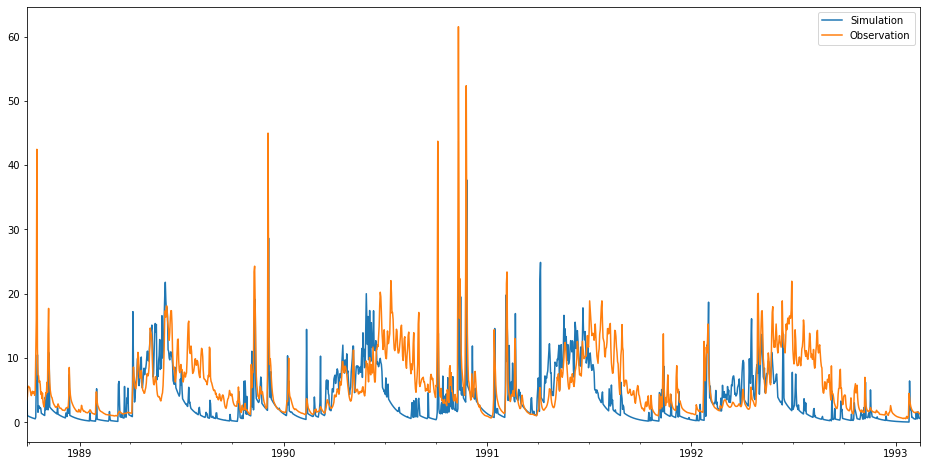

In [12]:
plt.figure(figsize=[16,8])
combined_discharge.simulation.iloc[1000:2600].plot(label='Simulation')
combined_discharge.streamflow.iloc[1000:2600].plot(label='Observation')
plt.legend();

## Clean up

In [42]:
model.finalize()

In [9]:
model.get_value_ptr('Elevation')

<PyCall.jlwrap Elevations(0.0, 500.0, 100.0, 250.0, 250.0)>

In [8]:
np.zeros((0,0))

array([], shape=(0, 0), dtype=float64)